## Import libraries and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels
from statsmodels.formula.api import ols
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk

# GEOPANDAS

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Data Summary and Goal

The data provided is a collection of records of successful house sales and those homes' living attributes, such as:

1. Number of Floors
2. Amount of living space
3. Price
4. Number of assorted rooms (bathrooms, bedrooms)
5. Location
6. ETC.


The goal of this project is to create a relatively accurate prediction model for the prices that future houses sell for. We will explore how different factors affect the pricing the homes, given the data, and compile the most important features into a compatible regression model.

The final result will be a flexible prediciton model(s) that allow for easy prediction of future price sales given certain criteria!

## Data Inspection and Cleaning

In [2]:
# Import data
df = pd.read_csv('../my_project_workspace_repo/data/kc_house_data.csv')

# Display shape and .head()
print(df.shape)
df.head()

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Check data types and missing values
df.info()
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [6]:
# Examine missing values

# df[df['yr_renovated'].isna()]
df['yr_renovated'].fillna(0)
# Replace all of the Null values with zeros so we can get a better idea of the amount of missing values in this column.
percent_missing = df[df['yr_renovated'] == 0].value_counts().sum() / df['yr_renovated'].value_counts().sum()
# A whopping 85% of the data is missing. Will this column be important at all for our conclusions? Will have to discuss with partner.



# df['waterfront'].fillna(0., inplace=True)
# df['view'].unique()
# The waterfront column only has a 1 or a 0 to specify if the house has a waterfront. The NaN values here can be treated as no waterfront.

# df.drop('view', axis=1, inplace=True)
# It is really unclear what 'view' even means, and there is no documentation that defines it. We will drop this column.

0.8510842016333428

In [ ]:
# Dealing with the 'sqft_basement' column. 

# Checking to see if my guess that all of the elements in the series are str types is true
for x in df['sqft_basement']:
    not_str_sqft = 0
    if type(x) != str:
        not_str_sqft += 1
        

# All of the elements in this series are of type str
if not_str_sqft == 0:
    # Replacing original series
    converted_to_str = pd.to_numeric(df['sqft_basement'], errors='coerce')
    df['sqft_basement'] = converted_to_str
    # Confirm that the series has been converted successfully
    if df['sqft_basement'].dtype == np.float64:
        pass
    



In [ ]:
# Now have to convert all of the dates in the 'date' column to something I can work with (a datetime object)
from datetime import datetime

for x in df['date']:
    not_str_date = 0
    if type(x) != str:
        not_str_date += 1
        
datetime_objects = []
if not_str_date == 0:
    for string in df['date']:
        string = pd.to_datetime(string)
        datetime_objects.append(string)
    df['date'] = datetime_objects

## Target and Features

In [ ]:
target = 'price'
dense_factors = ['sqft_living', 'sqft_lot','sqft_above','sqft_basement','sqft_living15', 'sqft_lot15']
sparse_factors = ['bedrooms', 'bathrooms', 'floors','view', 'grade']
category_factors = ['yr_built', 'yr_renovated', 'waterfront', 'condition']
other_factors = ['date', 'zipcode']

custom_factors = ['age', 'relative distance from nearest attraction', 'season']

## Collinearity check

AxesSubplot(0.125,0.125;0.62x0.755)


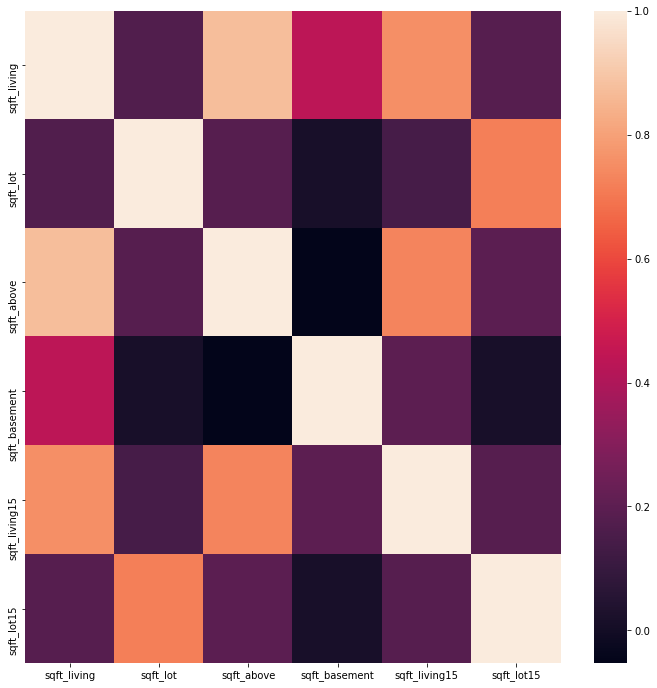

In [ ]:
# Preliminary collinearity check
fig, ax = plt.subplots(figsize=(12,12))
print(sns.heatmap(df[dense_factors].corr(), ax=ax))

## Date and Seasons and Age

In [ ]:
# Identify each sale by year
years = []
for date in df['date']:
    years.append(date.year)

df['sale_year'] = years
print(df['sale_year'].value_counts())
#

2014    14622
2015     6975
Name: sale_year, dtype: int64


In [ ]:
# Age of house at sale?



AttributeError: 'Series' object has no attribute 'year'

## Price Distribution

In [ ]:
price_mean = df['price'].mean()
price_std = df['price'].std()
price_mean, price_std

(540296.5735055795, 367368.1401013945)

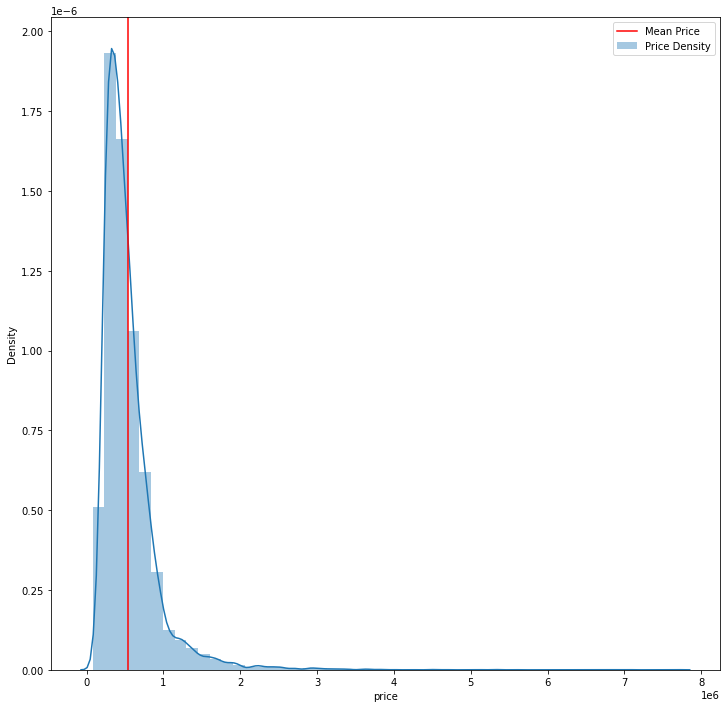

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.distplot(df['price'], label='Price Density')
plt.axvline(price_mean, color='red', label='Mean Price')
plt.legend()

## Floors

Text(0.5, 1.0, 'Avg Prices per Floor #')

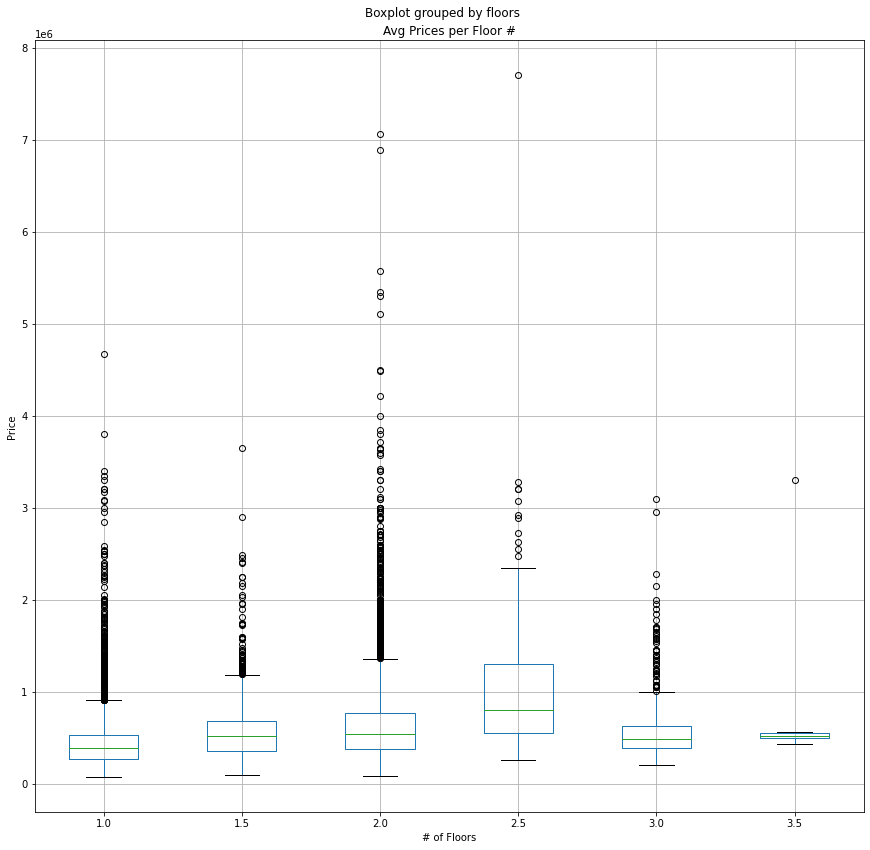

In [ ]:
df.boxplot('price', by='floors', figsize=(12,12))
plt.tight_layout()
plt.ylabel('Price')
plt.xlabel('# of Floors')
plt.title('Avg Prices per Floor #')

## Sqft_living

price          1.000000
sqft_living    0.701917
Name: price, dtype: float64

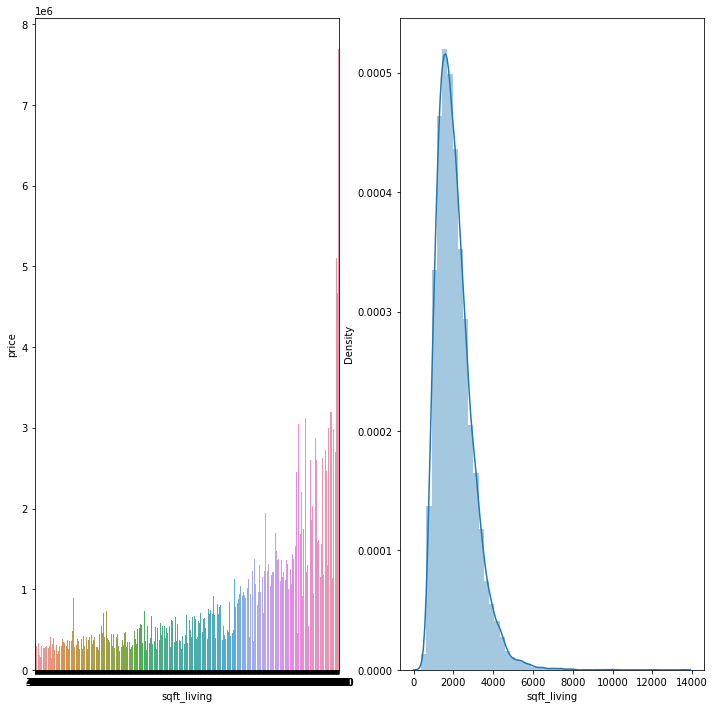

In [ ]:
# Bar plot of sqft_living to price
fig, axes = plt.subplots(1, 2, figsize=(12,12))
sns.barplot(x='sqft_living', y='price', data=df, ci=None, ax = axes[0])
sns.distplot(df['sqft_living'], ax=axes[1])
# The average of the living square feet is displayed with a red line on the pdf graph


# The results indicate a clear correlation between the living space size and the price. As living space size goes up, generally so does price.

# The strong correlation coefficient between the two variables helps validate this claim
df.corr()['price'][df.corr()['price'] >= .70]



In [ ]:
model2 = ols(formula='price~sqft_living', data=df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Mon, 19 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:54:16   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Location